In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import scipy.special as sp
import itertools

In [2]:
data_plot=pd.read_csv('prostate.data', sep='\t')
data_plot.drop(columns=data_plot.columns[0], inplace=True)

train=pd.Series(data_plot.loc[:,'train'])
data_plot.drop(columns='train', inplace=True)

lpsa=pd.Series(data_plot.loc[:,'lpsa'])
predictors=pd.DataFrame(data_plot.drop(columns='lpsa'))

# Selezionare i dati di training e testing
dataTrain = data_plot.loc[train == 'T'].reset_index(drop=True) #necessario resettare indici
dataTest = data_plot.loc[train == 'F'].reset_index(drop=True)

# Selezionare la serie 'lpsa' dai dati di training e testing
lpsaTrain = pd.Series(dataTrain['lpsa'])
lpsaTest = pd.Series(dataTest['lpsa'])

predictorsTrain=pd.DataFrame(dataTrain.drop(columns='lpsa'))
predictorsTest=pd.DataFrame(dataTest.drop(columns='lpsa'))

scaler = StandardScaler()
predictorsTrain_std = pd.DataFrame(scaler.fit_transform(predictorsTrain), columns=predictorsTrain.columns)
predictorsTest_std = pd.DataFrame(scaler.transform(predictorsTest), columns=predictorsTrain.columns)
#N=len(predictorsTrain_std)
#p=len(predictorsTrain_std.columns)+1
#train_intercept = np.empty(shape=(N, p), dtype=float)
#train_intercept[:, 0] = 1
#train_intercept[:, 1:p] = predictorsTrain_std.values

#ols = sm.OLS(lpsaTrain, train_intercept) #ols come variabili indipendenti accetta solo arraya numpy
#ols_result = ols.fit()
#ols_result.summary2()

In [3]:
data_train=sm.add_constant(predictorsTrain_std)
data_test=sm.add_constant(predictorsTest_std)

est=sm.OLS(lpsaTrain,data_train)
est2=est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     16.47
Date:                Thu, 23 May 2024   Prob (F-statistic):           2.04e-12
Time:                        19:11:43   Log-Likelihood:                -67.505
No. Observations:                  67   AIC:                             153.0
Df Residuals:                      58   BIC:                             172.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4523      0.087     28.182      0.0

In [4]:
# Preparazione spazio dati
varIndices = range(0,8)  # Assumendo 8 variabili da 0 a 7
nTotVars = len(predictorsTrain.columns) #8

nTotModels=0
for k in range(0, nTotVars+1):
    #print('K=',k)
    nTotModels=nTotModels+sp.binom(nTotVars,k) #coefficiente binomiale
    #print('nTotModels=', nTotModels) #totale modelli generati (256)

nTotModels=int(nTotModels)
# Array per memorizzare i risultati
models_NVars = np.zeros(nTotModels) #numero di variabili per modello
models_AICs = np.zeros(nTotModels) #aic index
models_BICs = np.zeros(nTotModels) #bic index
models_R2s = np.zeros(nTotModels) # rsquare /coefficient determination
models_SSR_train = np.zeros(nTotModels) #residual summare square on train
models_RMSE_test = np.zeros(nTotModels) #root mean square error on test
models_parIs = [None] * nTotModels  #parameters of the model

In [5]:
i = 0
for k in range(0, nTotVars + 1):
    selected_vars= np.zeros(k+1) # indici of selcted var (+1 for intercept)
    #print('k=',k)
    for subset in itertools.combinations(varIndices, k):
        #print("Subset:", subset)
        selected_vars[list(range(1,k+1))]=np.asarray(subset)+1  # salvo indici delle feature
        selected_vars=selected_vars.astype(int)
        #print(selected_vars)
        #if k==0:
        #    data_sel=np.ones((data_train.shape[0],1)) #solo intercept
        #else:
        data_sel = data_train.iloc[:, selected_vars]

        est = sm.OLS(lpsaTrain, data_sel) 
        est2 = est.fit()
        
        # Salvataggio dei risultati
        models_NVars[i] = k
        models_AICs[i] = est2.aic
        models_BICs[i] = est2.bic
        models_R2s[i] = est2.rsquared
        models_SSR_train[i] = est2.ssr
        models_parIs[i] = subset
        
        #test set
        models_RMSE_test[i]=0
        #if k==0:
        #    XTest_sel=np.ones((data_test.shape[0],1)) #solo intercept
        #else:
        XTest_sel = data_test.iloc[:,selected_vars]

        yTestpred= est2.predict(XTest_sel)
        
        RMSETest=(((yTestpred-lpsaTest)**2).mean())**0.5
        models_RMSE_test[i]=RMSETest
        
        i+=1
    


In [6]:
def plot_criteria(x,y):
    data_plot = pd.DataFrame({'NVars': x, 'Y': y})

    # Trova i valori minimi per ogni valore di NVars
    min_bics = data_plot.loc[data_plot.groupby('NVars')['Y'].idxmin()]
    #print(min_bics)
    # Plot dei punti
    plt.scatter(data_plot['NVars'], data_plot['Y'], label='Tutti i punti')

    # Plot dei punti minimi e la linea che li collega
    plt.plot(min_bics['NVars'], min_bics['Y'], color='red', marker='o')
    plt.show()

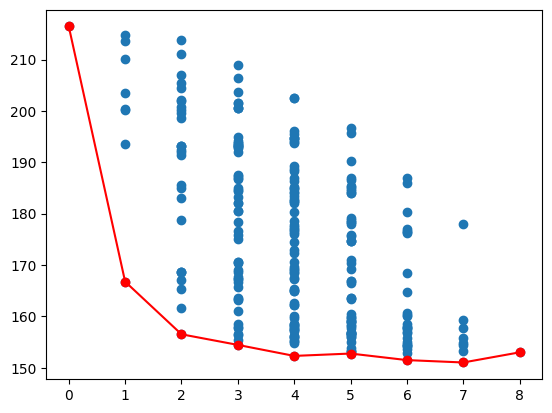

In [7]:
plot_criteria(models_NVars,models_AICs)

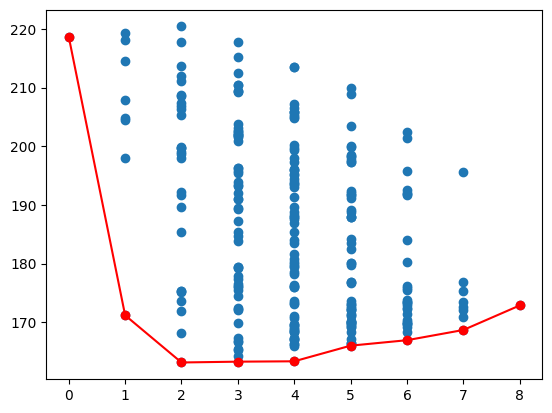

In [8]:
plot_criteria(models_NVars,models_BICs)

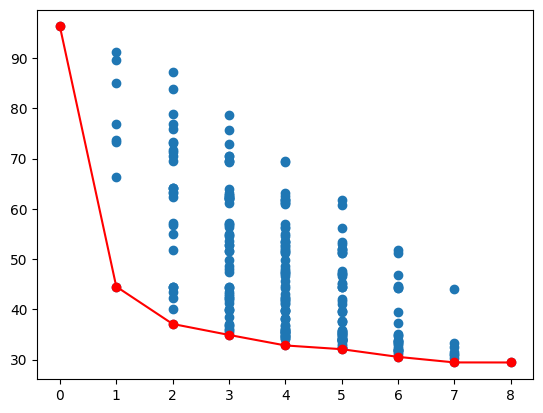

In [9]:
plot_criteria(models_NVars,models_SSR_train)

In [34]:
#forward selection
modelsFS_NVars = np.zeros(nTotVars+1) #numero di variabili per modello
modelsFS_AICs = np.zeros(nTotVars+1) #aic index
modelsFS_BICs = np.zeros(nTotVars+1) #bic index
modelsFS_R2s = np.zeros(nTotVars+1) # rsquare /coefficient determination
modelsFS_SSR_train = np.zeros(nTotVars+1) #residual summare square on train
modelsFS_RMSE_test = np.zeros(nTotVars+1) #root mean square error on test
modelsFS_parIs = [None] * (nTotVars+1)  #parameters of each the model/subset
selectedFS_vars=np.zeros(1)
selectedFS_vars=selectedFS_vars.astype(int)


def diff(first,second):
    second=set(second)
    return [item for item in first if item not in second]

for k in range(0,nTotVars+1):
    if(k==0):
        dataFS_sel=data_train.iloc[:,selectedFS_vars]
        est=sm.OLS(lpsaTrain,dataFS_sel)
        est2=est.fit()
        modelsFS_NVars[k] = k
        modelsFS_AICs[k] = est2.aic
        modelsFS_BICs[k] = est2.bic
        modelsFS_R2s[k] = est2.rsquared
        modelsFS_SSR_train[k] = est2.ssr
        modelsFS_parIs[k] = selectedFS_vars
        
        #Test Set
        XTest_sel = data_test.iloc[:,selectedFS_vars]
        yTestpred= est2.predict(XTest_sel)
        RMSETest=(((yTestpred-lpsaTest)**2).mean())**0.5
        modelsFS_RMSE_test[k]=RMSETest
    else:
        #find next best var and add to selVars FS
        bestvar= -1
        bestperfomance=float("inf")
        notselected_var=diff(list(range(0,9)),selectedFS_vars)
        
        for i in notselected_var:
            selectedFS_vars_tmp=np.append(selectedFS_vars, i)
            dataFS_sel_tmp=data_train.iloc[:,selectedFS_vars_tmp]
            est_tmp= sm.OLS(lpsaTrain,dataFS_sel_tmp)
            est2_tmp= est_tmp.fit()

            #Test Set
            XTest_sel_tmp = data_test.iloc[:,selectedFS_vars_tmp]
            yTestpred_tmp= est2_tmp.predict(XTest_sel_tmp)
            RMSETest_tmp=(((yTestpred_tmp-lpsaTest)**2).mean())**0.5
            #print(k,i,est2_tmp.ssr,bestperfomance,notselected_var)
            if est2_tmp.ssr < bestperfomance:
                modelsFS_NVars[k] = k
                modelsFS_AICs[k] = est2_tmp.aic
                modelsFS_BICs[k] = est2_tmp.bic
                modelsFS_R2s[k] = est2_tmp.rsquared
                modelsFS_SSR_train[k] = est2_tmp.ssr
                modelsFS_parIs[k]= selectedFS_vars_tmp
                modelsFS_RMSE_test[k]=RMSETest_tmp
                bestvar=i
                bestperfomance=est2_tmp.ssr

        if bestvar != -1:
            # Aggiorna selectedFS_vars con la nuova variabile selezionata
            selectedFS_vars = np.append(selectedFS_vars, bestvar)
        





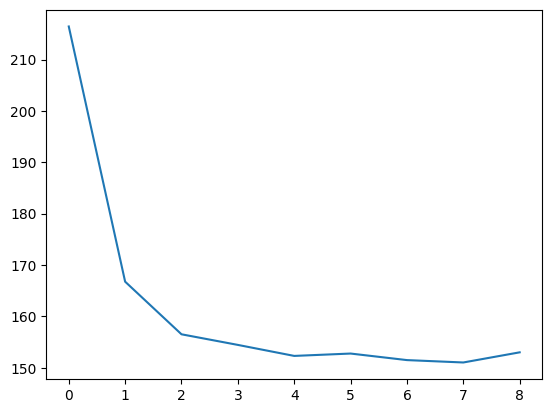

In [39]:
plt.plot(modelsFS_AICs)
plt.show()

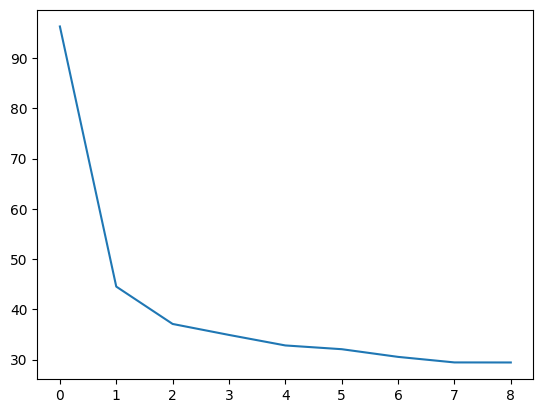

In [40]:
plt.plot(modelsFS_SSR_train)
plt.show()

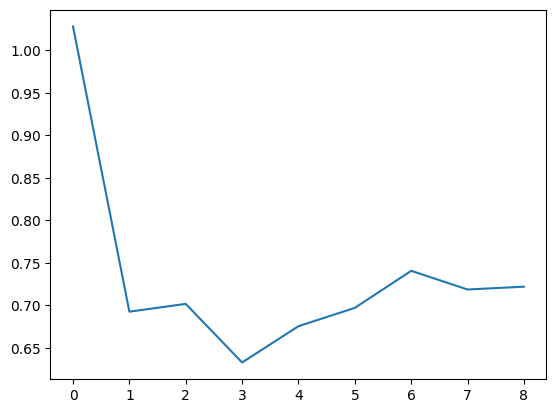

In [41]:
plt.plot(modelsFS_RMSE_test)
plt.show()

In [63]:
#backward selection
modelsBS_NVars = np.zeros(nTotVars+1) #numero di variabili per modello
modelsBS_AICs = np.zeros(nTotVars+1) #aic index
modelsBS_BICs = np.zeros(nTotVars+1) #bic index
modelsBS_R2s = np.zeros(nTotVars+1) # rsquare /coefficient determination
modelsBS_SSR_train = np.zeros(nTotVars+1) #residual summare square on train
modelsBS_RMSE_test = np.zeros(nTotVars+1) #root mean square error on test
modelsBS_parIs = [None] * (nTotVars+1)  #parameters of each the model/subset
selectedBS_vars=list(range(0,9))


def diff(first,second):
    second=set(second)
    return [item for item in first if item not in second]

for k in range(nTotVars,-1,-1):
    if(k==nTotVars):
        dataBS_sel=data_train
        est=sm.OLS(lpsaTrain,dataBS_sel)
        est2=est.fit()
        modelsBS_NVars[k] = k
        modelsBS_AICs[k] = est2.aic
        modelsBS_BICs[k] = est2.bic
        modelsBS_R2s[k] = est2.rsquared
        modelsBS_SSR_train[k] = est2.ssr
        modelsBS_parIs[k] = selectedBS_vars.copy()
        
        #Test Set
        XTest_sel = data_test
        yTestpred= est2.predict(XTest_sel)
        RMSETest=(((yTestpred-lpsaTest)**2).mean())**0.5
        modelsBS_RMSE_test[k]=RMSETest
    else:
        #find next best var and add to selVars BS
        bestvar= -1
        bestperfomance=float("inf")
        
        for i in range(1,len(selectedBS_vars)):
            selectedBS_vars_tmp=selectedBS_vars.copy()
            del selectedBS_vars_tmp[i]
            dataBS_sel_tmp=data_train.iloc[:,selectedBS_vars_tmp]
            est_tmp= sm.OLS(lpsaTrain,dataBS_sel_tmp)
            est2_tmp= est_tmp.fit()

            #Test Set
            XTest_sel = data_test.iloc[:,selectedBS_vars_tmp]
            yTestpred= est2_tmp.predict(XTest_sel)
            RMSETest=(((yTestpred-lpsaTest)**2).mean())**0.5
            #print(k,i,est2_tmp.ssr,bestperfomance,notselected_var)
            if est2_tmp.ssr < bestperfomance:
                modelsBS_NVars[k] = k
                modelsBS_AICs[k] = est2_tmp.aic
                modelsBS_BICs[k] = est2_tmp.bic
                modelsBS_R2s[k] = est2_tmp.rsquared
                modelsBS_SSR_train[k] = est2_tmp.ssr
                modelsBS_parIs[k]= selectedBS_vars_tmp
                modelsBS_RMSE_test[k]=RMSETest
                bestvar=i
                bestperfomance=est2_tmp.ssr

        if bestvar != -1:
            selectedBS_vars = modelsBS_parIs[k].copy()

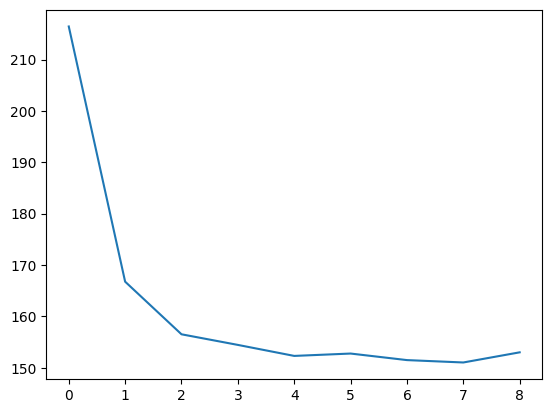

In [64]:
plt.plot(modelsBS_AICs)

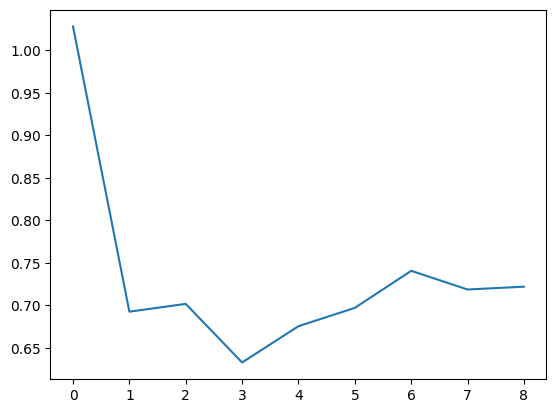

In [65]:
plt.plot(modelsBS_RMSE_test)

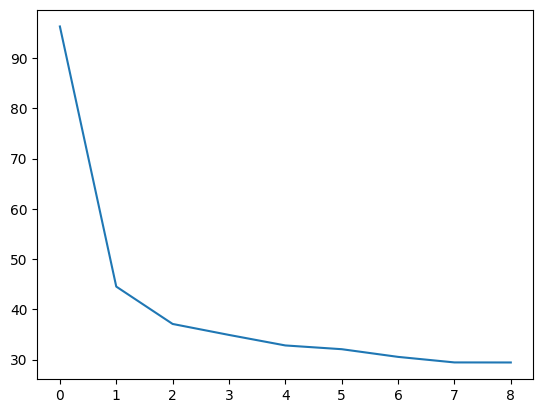

In [60]:
plt.plot(modelsBS_SSR_train)

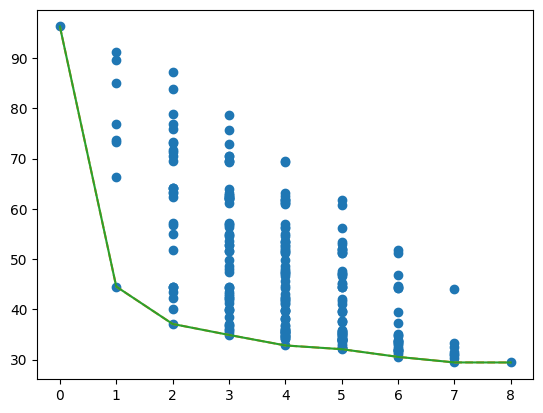

In [77]:
plt.plot(models_NVars,models_SSR_train, 'o')
plt.plot(modelsFS_SSR_train,  linestyle='--')
plt.plot(modelsBS_SSR_train)